## cDCGAN for Ising model dataset
In this notebook I create a conditional deep convolutional GAN to generate Ising model configurations at specific temperatures. The generator and discriminator are constructed using the tf.keras Functional API


In [1]:
import tensorflow as tf
tf.enable_eager_execution()

%matplotlib inline
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import keras
import glob
import imageio
import PIL
import time

from IPython import display

## Load data
For a GAN, we don't need a validation set, only load the training set.

The labels for the configurations are now the actual temperatures used in the Monte Carlo simulations. I am using configurations from a 40x40 spin Ising system.

For the temerature labels, I round to the nearest 10th degree. For example: 2.25 --> 2.3

Then, I assign an interger value to each temperature, starting with 0 for the lowest temp.

In [2]:
train_data = '../../../data/Ising/train40v2/'

In [3]:
def one_hot_label(img):
    label,T,_,_ = img.split('_')
    if label == 'low':
        ohl = np.array([1,0])
    elif label == 'high':
        ohl = np.array([0,1])
    return ohl,np.round((float(T)-1.5)/0.1)
def train_data_with_label(train_path,*args):
    train_images = []
    if args:
        for category in args:
            for i in tqdm(os.listdir(train_path + category)):
                path = os.path.join(train_path, category,i)
                img = np.load(path)
                train_images.append([img, one_hot_label(i)])
        shuffle(train_images)
        return train_images

In [4]:
train_set=train_data_with_label(train_data,'low','high')

100%|██████████| 8000/8000 [00:02<00:00, 3637.41it/s]


In [5]:
tr_img_data = np.array([i[0] for i in train_set]).reshape(-1,40,40,1)
tr_img_data_float = tr_img_data.astype(dtype='float32')

I like the keras.to_categotical utility. So, to use it here, 
I determine how many unique temperature were used in the simulations and create a one-hot encoding for each.

In [6]:
tr_lbl_data = np.array([i[1][1] for i in train_set])

In [7]:
len(np.unique(tr_lbl_data))

17

In [8]:
np.unique(tr_lbl_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

In [9]:
train_labels_emb = tf.keras.utils.to_categorical(tr_lbl_data, 17)

In [27]:
BUFFER_SIZE = 15000
BATCH_SIZE = 128

Create a tensorflow dataset object that acts as a pipeline for feeding data to the model.

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((tr_img_data_float,train_labels_emb)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Define the generator
I use the tf.keras Functional API to define a net that takes as input a random noise vector of length 100, and a one-hot encoding of the temperature. Then, an embedding is greated from the temperature label and concatenated with the first fully connected layer from the noise input.

Then, there are 3 Transverse Convolutional layers, the latter two of which upscale the previous layer output.
The final output is a 40x40 tensor, the same dimensions as the Ising array I am training against.

In [12]:
def make_generator_model():
    # Input is x (noise) and y (label)
    # Input x
    input_x = tf.keras.layers.Input(shape=(100,), name='noise_input')
    x = tf.keras.layers.Dense(10*10*256,use_bias=False)(input_x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    reshape_x = tf.keras.layers.Reshape((10, 10, 256))(x)
    
    # Input y
    input_y = tf.keras.layers.Input(shape=(17,), name='label_input')
    y = tf.keras.layers.Dense(10*10*128,use_bias=False)(input_y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.LeakyReLU()(y)
    
    reshape_y = tf.keras.layers.Reshape((10, 10, 128))(y)
    
    # Combine Inputs
    xy = tf.keras.layers.concatenate([reshape_x, reshape_y])
    
    # First Transpose Conv layer (no upscale)
    xy = tf.keras.layers.Conv2DTranspose(128,(5,5),strides=(1, 1), padding='same', use_bias=False)(xy)
    xy = tf.keras.layers.BatchNormalization()(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)
    
    # Second Transpose Conv layer (upscale)
    xy = tf.keras.layers.Conv2DTranspose(64,(5,5),strides=(2, 2), padding='same', use_bias=False)(xy)
    xy = tf.keras.layers.BatchNormalization()(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)
    
    # Third Transpose Conv layer (upscale)
    xy_final = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(xy)
    
    model = tf.keras.Model(inputs=[input_x, input_y], outputs=xy_final)
  
    return model

## Define the Discriminator
This net takes a 40x40 configuration input and the one-hot temperature label.

The Configuration input is passed through two convolutional layers and the label input is passed through two fully connected layers. Then, they are combined and passed through a fully connected layer to the output layer.

I made this Discriminator "weak" by only allowing 16 filter for the first conv layer, and 32 for the second. This helps prevent the discriminator from overpowering the generator.

In [48]:
def make_discriminator_model():
    
    # Input is x (noise) and y (label)
    # First Conv layer
    input_x = tf.keras.layers.Input(shape=(40,40,1), name='image_input')
    x = tf.keras.layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same')(input_x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Second Conv layer
    x = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    #reshape_x = tf.keras.layers.Reshape((7, 7, 256))(x)
    
    input_y = tf.keras.layers.Input(shape=(17,), name='label_input')
    y = tf.keras.layers.Dense(1024)(input_y)
    y = tf.keras.layers.LeakyReLU()(y)
    
    y = tf.keras.layers.Dense(10*10*128)(y)
    y = tf.keras.layers.LeakyReLU()(y)
    y = tf.keras.layers.BatchNormalization()(y)
    
    reshape_y = tf.keras.layers.Reshape((10, 10, 128))(y)
    
    xy = tf.keras.layers.concatenate([x, reshape_y])
    
    xy = tf.keras.layers.Flatten()(xy)
    xy = tf.keras.layers.Dense(1024)(xy)
    xy = tf.keras.layers.LeakyReLU()(xy)
    
    xy_final = tf.keras.layers.Dense(1)(xy)
    #xy_final = tf.keras.layers.Si
    
    model = tf.keras.Model(inputs=[input_x, input_y], outputs=xy_final)

    return model

In [49]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [35]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [36]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [37]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [38]:
checkpoint_dir = './training_checkpoints_cGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Now, set up a random noise vector to monitor the performance as the GAN trains. The labels attached to the noise vector start from the lowest temperature and increase.

In [19]:
noise_dim = 100
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])
tmpList=np.arange(16)

labels_for_generation = tf.keras.utils.to_categorical(tmpList,17)


In [20]:
def train_step(images,labels,gen_loss_log,disc_loss_log):
   # generating noise from a normal distribution
      current_batch_size = tf.shape(labels)[0]
      noise = tf.random_normal([current_batch_size, noise_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,labels], training=True)
      
        real_output = discriminator([images,labels], training=True)
        generated_output = discriminator([generated_images,labels], training=True)
         
        gen_loss = generator_loss(generated_output)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_output, generated_output)
        disc_loss_log.append(disc_loss)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [21]:
#train_step = tf.contrib.eager.defun(train_step)

In [22]:
def train(dataset, epochs,gen_loss_log,disc_loss_log):  
  for epoch in range(epochs):
    start = time.time()
    
    for batch in dataset:
      images = batch[0]
      lbls = batch[1]
      train_step(images,lbls,gen_loss_log,disc_loss_log)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epoch + 1,
                               random_vector_for_generation,labels_for_generation)
    
    # saving (checkpoint) the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
    #generating after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           random_vector_for_generation,labels_for_generation)


Define a helper function to plot and save images.

In [83]:
def generate_and_save_images(model, epoch, test_input_noise,test_input_labels):
    #predictions = model([test_input_noise,test_input_labels], training=False)
    predictions = tf.round(model([test_input_noise,test_input_labels], training=False))

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the cDCGAN!

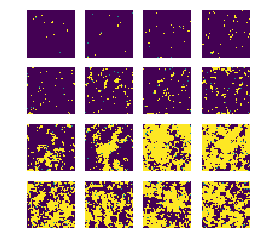

CPU times: user 16min 33s, sys: 1min 3s, total: 17min 37s
Wall time: 22min 14s


In [84]:
%%time
EPOCHS = 60
#gen_loss_log=[]
#disc_loss_log=[]
train(train_dataset, EPOCHS,gen_loss_log,disc_loss_log)

### Plot generator and discriminator loss over training

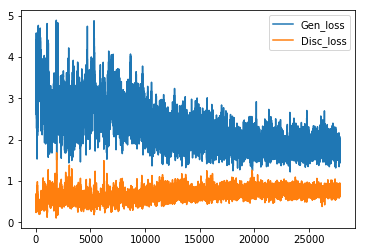

In [89]:
plt.plot(np.asarray(gen_loss_log),label="Gen_loss")
plt.plot(np.asarray(disc_loss_log),label="Disc_loss")
plt.legend(loc='upper right')

In [90]:
np.save('GeneratorLoss_cGAN.npy',np.asarray(gen_loss_log))
np.save('DiscriminatorLoss_cGAN.npy',np.asarray(disc_loss_log))

# Performance
## Generated Output

After training the GAN for ~150 epochs we arrive at some nice looking results!
Below I plot the generator output for an array of temperatures, starting from low going to high. We see the generator has captured the correct trend. At low T, most of the spins are aligned. As T increases more clusters of alighned spins form and for the highest T we have reduced correlation between neighboring spins.

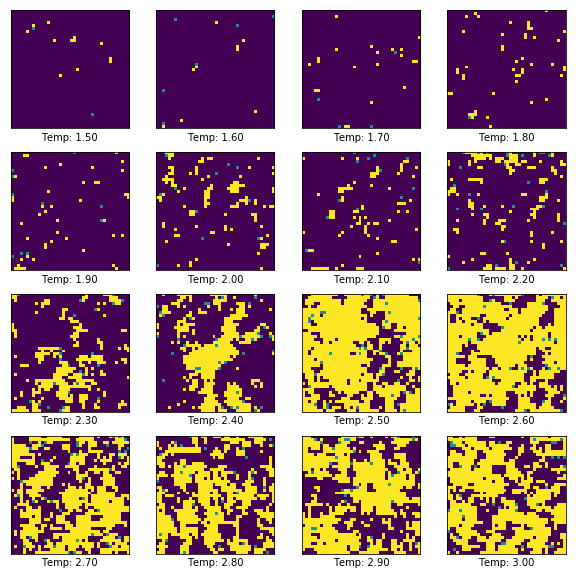

In [102]:
predictions = tf.round(generator([random_vector_for_generation,labels_for_generation], training=False))

fig = plt.figure(figsize=(10,10))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predictions[i, :, :, 0])
    #plt.axis('off')
    temp = 1.5+i*0.1
    plt.xlabel(f'Temp: {temp:.2f}')

#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()

## Simulation Data
Below I plot simulation samples for the same set of temperatures. This shows that the GAN does an excellent job generating configurations for different temperatures.

Side note: The fact the at low temperatures there is varaition between being mostly purple vs mostly yellow is irrelevant. What matters is that it is mostly one color with only a few fluctuating spins.

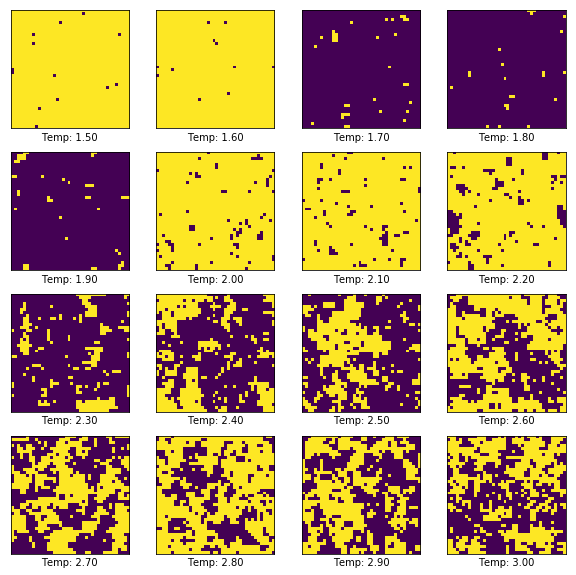

In [116]:
#np.where(tr_lbl_data==0)[0][0]

fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tr_img_data[np.where(tr_lbl_data==i)[0][1], :, :, 0])
    #plt.axis('off')
    temp = 1.5+i*0.1
    plt.xlabel(f'Temp: {temp:.2f}')

#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()

## Final Note
Improvement can be made, but these are excellent results so far. The next step will be to do some statistical analysis of the generated configurations to see how it compares to the simulations. Specifically, we know from theory how the spin-spin correlation function and correlation length should scale with temperature. It will be intersting to see where these statistical properties are upheld in the generated configurations. More to come!

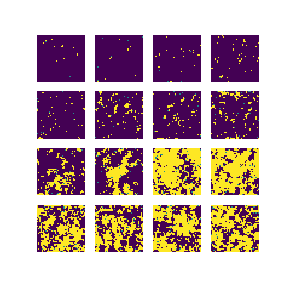

In [117]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [92]:
with imageio.get_writer('c_dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
    
# this is a hack to display the gif inside the notebook
os.system('cp c_dcgan.gif c_dcgan.gif.png')

0

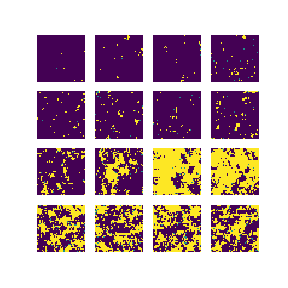

In [93]:
display.Image(filename="c_dcgan.gif.png")